In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# from scipy.fftpack import fftn, ifftn
from scipy.fft import fftn, ifftn
# from scipy.fft import fft2, ifft2
from matplotlib import animation

$$
\frac{\partial c}{\partial t} = M \nabla^2 \left[ \frac{\delta F}{\delta c} \right] = M \left[-\kappa \nabla^4 c + \nabla^2 f' (c) \right]
$$

$c$: 濃度, $t$: 時間, $M$: モビリティ, $F$: 自由エネルギー関数, $\kappa$: 内部エネルギーに関連するパラメータ, $f$: 内部自由エネルギー密度

自由エネルギー関数は以下のように与えられる。

$$
F [c] = \int \left[ \frac{\kappa}{2} (\nabla c(r))^2 + f(c) \right] \text{d}r
$$

内部エネルギー密度は以下のよう与えられる。

$$
f(c) = W c^2 (1 - c)^2
$$

c0 =  0.007816674


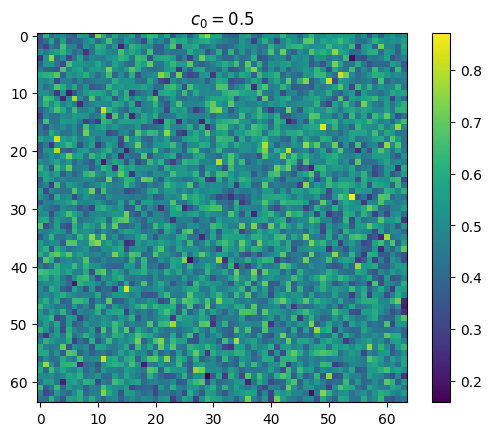

In [3]:
# 初期値の設定

n_steps = 10000  # ステップ数
dt = 0.1  # 時間刻み
N = 64  # サイズ
dx = 1.0
noise = 0.1
c0 = 0.5
rng = np.random.default_rng(12345)  # the seed of random numbers generator


# c_hat = np.empty((N, N, N), dtype=np.complex64)
# dfdc_hat = np.empty((N, N, N), dtype=np.complex64)
# c = np.empty((n_steps, N, N, N), dtype=np.float32)
c_hat = np.empty((N, N), dtype=np.complex64)
dfdc_hat = np.empty((N, N), dtype=np.complex64)
c = np.empty((n_steps, N, N), dtype=np.float32)
L = N * dx

c[0] = c0 + noise * rng.standard_normal(c[0].shape)

print("c0 = ", c[0].sum() * dx**2 / L**3)

plt.imshow(c[0])
plt.colorbar(cmap="RdBu_r")
plt.title("$c_0=%.1f$" % c0)
plt.savefig("cahn-hilliard-input.png")
plt.show()

In [4]:
def finterf(c_hat, kappa, K2):
    """内部自由エネルギー密度


    """
    return kappa * ifftn(K2 * c_hat**2).real


def fbulk(c, W):
    """バルクの自由エネルギー密度

    f(c) = Wc^2(1-c)^2

    Parameters
    ----------
    c : _type_
        _description_
    W : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    return W * c**2 * (1 - c) * c**2


def dfdc(c, W):
    """バルクの自由エネルギー密度の微分

    Parameters
    ----------
    c : _type_
        _description_
    W : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    return 2 * W * (c * (1 - c) ** 2 - (1 - c) * c**2)

In [ ]:
W = 2.0
M = 1.0  # mobility
kappa = 0.5  # gradient coeficient

# 2次元フーリエ変換のための波数ベクトルの設定
# kx = ky = kz = np.fft.fftfreq(N, d=dx) * 2 * np.pi
# K = np.array(np.meshgrid(kx, ky, kz, indexing="ij"), dtype=np.float32)
kx = ky = np.fft.fftfreq(N, d=dx) * 2 * np.pi
K = np.array(np.meshgrid(kx, ky, indexing="ij"), dtype=np.float32)
K2 = np.sum(K * K, axis=0, dtype=np.float32)

# アンチエイリアス処理
kmax_dealias = kx.max() * 2.0 / 3.0  # ナイキストモード
dealias = np.array(
    (np.abs(K[0]) < kmax_dealias) * (np.abs(K[1]) < kmax_dealias), dtype=bool
)

c_hat[:] = fftn(c[0])
for i in tqdm(range(1, n_steps)):
    dfdc_hat[:] = fftn(dfdc(c[i - 1], W))  # the FT of the derivative
    dfdc_hat *= dealias  # dealising
    c_hat[:] = (
        (c_hat - dt * K2 * M * dfdc_hat)
        / (1 + dt * M * kappa * K2**2)
    )  # updating in time
    print(c.shape)
    print(c_hat.shape)
    print(ifftn(c_hat).real.shape)
    c[i] = ifftn(c_hat).real  # inverse fourier transform

100%|██████████| 9999/9999 [00:00<00:00, 11429.36it/s]


c =  0.007816674
relative_error =  0.0


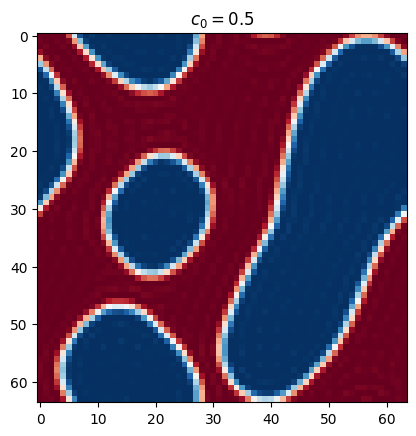

In [6]:
print("c = ", c[-1].sum() * dx**2 / L**3)

print("relative_error = ", np.abs(c[-1].sum() - c[0].sum()) / c[0].sum())
plt.imshow(c[-1], cmap="RdBu_r", vmin=0.0, vmax=1.0)
plt.title("$c_0=%.1f$" % c0)
plt.savefig("cahn-hilliard-c0-%.1f.png" % c0)
plt.show()

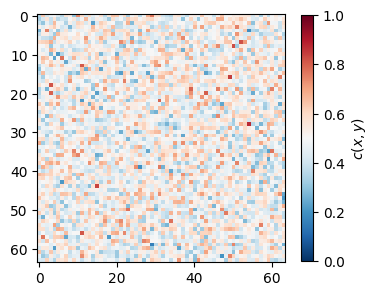

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(c[0], cmap="RdBu_r", vmin=0.0, vmax=1.0)
cb = fig.colorbar(im, ax=ax, label=r"$c(x,y)$", shrink=0.8)
# tx = ax.text(
#     L, 20, "t={:.1f}".format(0.0), bbox=dict(boxstyle="round", ec="white", fc="white")
# )

plt.show()

def animate(i):
    im.set_data(c[i])
    im.set_clim(0.0, 1.0)
    ax.set_title(f"$c_0={c0:.1f}$ ({i * 50:.1f} frame)")
    # tx.set_text("t={:.1f}".format(5*i*dt))
    return fig

ani = animation.FuncAnimation(fig, animate, frames=int(n_steps / 50))
ani.save("ch-c0=" + str(c0) + ".gif", writer="pillow", fps=24, dpi=100)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (50,50,50)  and requested shape (51,51,51)

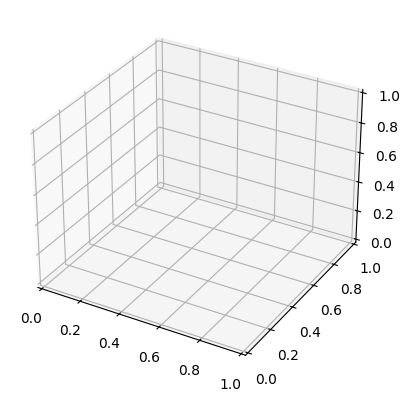

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def laplacian(u, dx):
    return (np.roll(u, -1, axis=0) + np.roll(u, 1, axis=0) +
            np.roll(u, -1, axis=1) + np.roll(u, 1, axis=1) +
            np.roll(u, -1, axis=2) + np.roll(u, 1, axis=2) - 6 * u) / dx**2

def cahn_hilliard_3d(u, dt, dx, kappa, M, n_steps):
    for step in range(n_steps):
        lap_u = laplacian(u, dx)
        lap_u3 = laplacian(u**3, dx)
        mu = -laplacian(u, dx) + u**3 - u
        u += dt * M * laplacian(mu, dx)
    return u

def initialize(N, noise_level=0.01):
    u = np.random.rand(N, N, N) * noise_level
    return u

def plot_3d(u, threshold=0.5):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = np.indices(u.shape)
    ax.voxels(x - 1, y - 1, z - 1, u > threshold, edgecolor='k')
    plt.show()

# Parameters
N = 50  # Grid size
dx = 1.0  # Grid spacing
dt = 0.01  # Time step
kappa = 1.0  # Interfacial energy coefficient
M = 1.0  # Mobility
n_steps = 100  # Number of time steps

# Initial condition
u = initialize(N)

# Solve Cahn-Hilliard equation
u = cahn_hilliard_3d(u, dt, dx, kappa, M, n_steps)

# Plot the result
plot_3d(u)

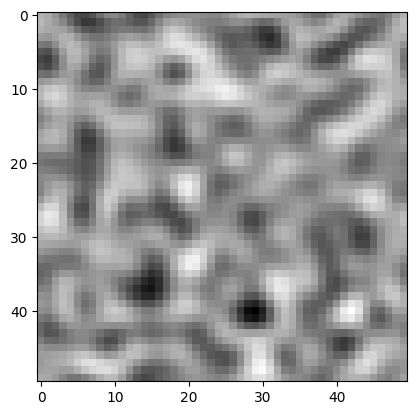

In [ ]:
plt.imshow(u[40], "gray")

Step: 0
Step: 1000
Step: 2000
Step: 3000
Step: 4000
Step: 5000
Step: 6000
Step: 7000
Step: 8000
Step: 9000


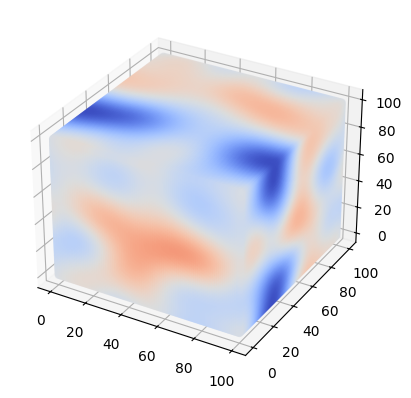

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# パラメータの設定
Lx, Ly, Lz = 100, 100, 100  # システムサイズ
Nx, Ny, Nz = 100, 100, 100  # 格子点数
dx, dy, dz = Lx / Nx, Ly / Ny, Lz / Nz  # 格子間隔
dt = 0.01  # 時間間隔
M = 1.0  # 移動度
kappa = 1.0  # 勾配エネルギー係数
A = 1.0  # 自由エネルギー密度の係数
steps = 10000  # 時間ステップ数

# 初期条件
np.random.seed(0)
phi = np.random.rand(Nx, Ny, Nz) * 0.2 - 0.1  # 初期オーダーパラメータ

# ラプラシアンの計算
def laplacian(f):
    lap = (np.roll(f, 1, axis=0) + np.roll(f, -1, axis=0) - 2 * f) / dx**2 \
        + (np.roll(f, 1, axis=1) + np.roll(f, -1, axis=1) - 2 * f) / dy**2 \
        + (np.roll(f, 1, axis=2) + np.roll(f, -1, axis=2) - 2 * f) / dz**2
    return lap

# 時間発展
for step in range(steps):
    mu = A * phi * (1 - phi) * (1 - 2 * phi) - kappa * laplacian(phi)
    phi += dt * M * laplacian(mu)

    if step % 1000 == 0:
        print(f"Step: {step}")

# 結果のプロット
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
z = np.linspace(0, Lz, Nz)
X, Y, Z = np.meshgrid(x, y, z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=phi.flatten(), cmap='coolwarm')
plt.show()

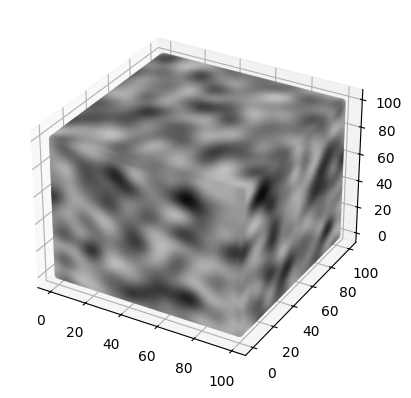

In [ ]:
phi2 = 2 * (phi - np.min(phi)) / (np.max(phi) - np.min(phi)) - 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=phi2.flatten(), cmap="gray")
plt.show()

In [ ]:
phi2.min()

np.float64(-1.0)

In [ ]:
phi2.max()

np.float64(1.0)